In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import pandas as pd
import joblib
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, MaxPool2D, LSTM, GRU, Reshape, Flatten, Dropout

In [2]:
X = np.array(joblib.load("reduced_numpy_videos.pkl"))
df = pd.read_csv("reduced_dataset.csv", header = 0, index_col=0)

In [3]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
558,25,-1,1,4,32,signschool,val,https://signstock.blob.core.windows.net/signsc...,0,626,485,85,1608,1080,accident
559,25,-1,1,5,6,signschool,val,https://signstock.blob.core.windows.net/signsc...,1,627,662,54,1434,1080,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,25,-1,1,1,115,aslbrick,train,http://aslbricks.org/New/ASL-Videos/take.mp4,0,69500,166,43,952,720,take
334,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/what.mp4,1,69531,155,34,1067,720,what
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


## Prepare dataset

In [4]:
encoder = pickle.load(open("reduced one hot encoder", 'rb'))
y = encoder.transform(np.array(list(df["gloss"])).reshape(-1,1)).toarray()

In [5]:
le = pickle.load(open("reduced label encoder", 'rb'))
y_ = le.transform(np.array(list(df["gloss"])))

In [6]:
y_.shape

(883,)

In [7]:
print(X.shape, y.shape)

(883, 64, 64, 64, 3) (883, 80)


In [8]:
IMG_SHAPE = X.shape[1:]
nb_classes = y.shape[-1]

## Model implementation

In [9]:
mobileNet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE[1:],
    alpha=1.0,
    include_top=False,
    weights="imagenet"
)

In [10]:
mobileNet.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 32, 32, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 32, 32, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

In [11]:
for layer in mobileNet.layers:
    layer.trainable = False

In [12]:
dense_layer_after_mobile_net = Dense(32, activation='relu')
flatten_layer = Flatten()

In [18]:
input_layer = Input(shape=IMG_SHAPE)
split_layer = tf.split(input_layer, IMG_SHAPE[0], axis=1, num=None, name='split')
features = []
for layer in split_layer:
    reshape_layer = Reshape(IMG_SHAPE[1:])(layer)
    feature = mobileNet(reshape_layer)
    feature_flat = flatten_layer(feature)
    features.append(feature_flat)
features = tf.stack(features, axis = 1)
lstm_layer = LSTM(64)(features)
dense_layer = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(nb_classes, activation='softmax')(dense_layer)

model = Model(input_layer, output_layer)
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.split_2 (TFOpLambda)        [(None, 1, 64, 64,   0           ['input_4[0][0]']                
                                3),                                                               
                                 (None, 1, 64, 64,                                                
                                3),                                                               
                                 (None, 1, 64, 64,                                          

Epoch 1/10
10/10 [==============================] - 419s 42s/step - loss: 4.4210 - accuracy: 0.0085 - val_loss: 4.3903 - val_accuracy: 0.0136
Epoch 2/10
10/10 [==============================] - 449s 46s/step - loss: 4.3892 - accuracy: 0.0102 - val_loss: 4.3857 - val_accuracy: 0.0102
Epoch 3/10
10/10 [==============================] - 464s 47s/step - loss: 4.3858 - accuracy: 0.0136 - val_loss: 4.3839 - val_accuracy: 0.0102
Epoch 4/10
10/10 [==============================] - 491s 50s/step - loss: 4.3822 - accuracy: 0.0170 - val_loss: 4.3846 - val_accuracy: 0.0136
Epoch 5/10
10/10 [==============================] - 555s 57s/step - loss: 4.3814 - accuracy: 0.0136 - val_loss: 4.3851 - val_accuracy: 0.0102
Epoch 6/10
10/10 [==============================] - 925s 97s/step - loss: 4.3800 - accuracy: 0.0136 - val_loss: 4.3848 - val_accuracy: 0.0102
Epoch 7/10
10/10 [==============================] - 620s 58s/step - loss: 4.3786 - accuracy: 0.0153 - val_loss: 4.3848 - val_accuracy: 0.0068
Epoch 

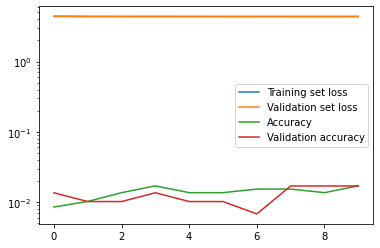

Epoch 1/10
10/10 [==============================] - 746s 75s/step - loss: 4.3829 - accuracy: 0.0170 - val_loss: 4.3747 - val_accuracy: 0.0170
Epoch 2/10
10/10 [==============================] - 792s 81s/step - loss: 4.3815 - accuracy: 0.0170 - val_loss: 4.3752 - val_accuracy: 0.0136
Epoch 3/10
10/10 [==============================] - 842s 85s/step - loss: 4.3817 - accuracy: 0.0102 - val_loss: 4.3774 - val_accuracy: 0.0204
Epoch 4/10
10/10 [==============================] - 872s 89s/step - loss: 4.3815 - accuracy: 0.0102 - val_loss: 4.3776 - val_accuracy: 0.0170
Epoch 5/10
10/10 [==============================] - 1239s 129s/step - loss: 4.3812 - accuracy: 0.0170 - val_loss: 4.3772 - val_accuracy: 0.0170
Epoch 6/10
10/10 [==============================] - 1447s 147s/step - loss: 4.3790 - accuracy: 0.0187 - val_loss: 4.3765 - val_accuracy: 0.0170
Epoch 7/10
10/10 [==============================] - 1486s 150s/step - loss: 4.3781 - accuracy: 0.0170 - val_loss: 4.3770 - val_accuracy: 0.0170



KeyboardInterrupt



In [21]:
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [ ]:
y_pred1 = model.predict(X)         
y_pred1 = np.argmax(y_pred1, axis = 1)

In [ ]:
print("F1 score : ", f1_score(y_, y_pred1, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred1))
print("Precision score : ", precision_score(y_, y_pred1, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred1, average = 'weighted'))

In [ ]:
y_pred2 = model.predict(X2)         
y_pred2 = np.argmax(y_pred2, axis = 1)

In [ ]:
print("F1 score : ", f1_score(y_2, y_pred2, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_2, y_pred2))
print("Precision score : ", precision_score(y_2, y_pred2, average = 'weighted'))
print("Recall score : ", recall_score(y_2, y_pred2, average = 'weighted'))

### Another model

In [9]:
model2 = Sequential()
model2.add(Input(shape=(IMG_SHAPE)))
model2.add(Conv2D(filters=8, kernel_size= 3, strides = 2, padding='same', activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=3, strides = 2, padding='same', activation='relu'))
model2.add(Conv2D(filters=32, kernel_size= 3, strides = 2,padding='same', activation='relu'))
model2.add(Conv2D(filters=64, kernel_size= 3, strides = 2,padding='same', activation='relu'))
model2.add(tf.keras.layers.Reshape((64, 4*4*64)))
model2.add(LSTM(64))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 32, 32, 8)     224       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 16, 16, 16)    1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 8, 8, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 4, 4, 64)      18496     
                                                                 
 reshape (Reshape)           (None, 64, 1024)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                278784    
                                                                 
 dense (Dense)               (None, 128)               8

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 4.0937 - accuracy: 0.0578 - val_loss: 4.5835 - val_accuracy: 0.0136
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 4.0317 - accuracy: 0.0646 - val_loss: 4.6394 - val_accuracy: 0.0169
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 3.9782 - accuracy: 0.0765 - val_loss: 4.6309 - val_accuracy: 0.0203
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 3.9035 - accuracy: 0.0833 - val_loss: 4.7316 - val_accuracy: 0.0203
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 3.8027 - accuracy: 0.0986 - val_loss: 4.7415 - val_accuracy: 0.0271
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: 3.7186 - accuracy: 0.0952 - val_loss: 4.8085 - val_accuracy: 0.0169
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 3.6497 - accuracy: 0.1139 - val_loss: 4.8086 - val_accuracy: 0.0305
Epoch 8/10
10/10 [==

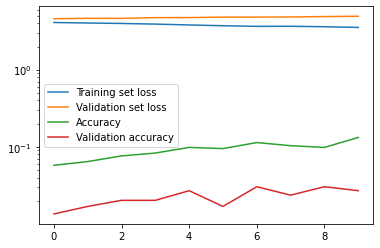

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 4.2145 - accuracy: 0.0764 - val_loss: 3.6456 - val_accuracy: 0.1224
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 4.0523 - accuracy: 0.0866 - val_loss: 3.7038 - val_accuracy: 0.1054
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 3.9114 - accuracy: 0.1036 - val_loss: 3.6918 - val_accuracy: 0.1327
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 3.7831 - accuracy: 0.1154 - val_loss: 3.7033 - val_accuracy: 0.1190
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 3.7121 - accuracy: 0.1239 - val_loss: 3.7374 - val_accuracy: 0.1088
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: 3.5921 - accuracy: 0.1562 - val_loss: 3.7428 - val_accuracy: 0.0850
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 3.4891 - accuracy: 0.1885 - val_loss: 3.8033 - val_accuracy: 0.0850
Epoch 8/10
10/10 [==

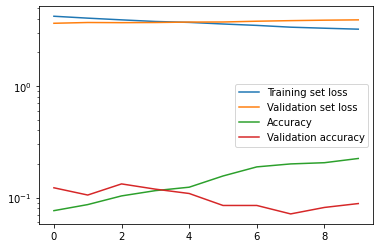

Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 3.6704 - accuracy: 0.1307 - val_loss: 3.0585 - val_accuracy: 0.2415
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 3.5760 - accuracy: 0.1409 - val_loss: 3.2524 - val_accuracy: 0.1939
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 3.5272 - accuracy: 0.1613 - val_loss: 3.4086 - val_accuracy: 0.1395
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 3.5106 - accuracy: 0.1392 - val_loss: 3.4131 - val_accuracy: 0.1497
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 3.3486 - accuracy: 0.1562 - val_loss: 3.5036 - val_accuracy: 0.1293
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 3.2060 - accuracy: 0.2122 - val_loss: 3.4603 - val_accuracy: 0.1190
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 3.0841 - accuracy: 0.2309 - val_loss: 3.5528 - val_accuracy: 0.1122
Epoch 8/10
10/10 [==

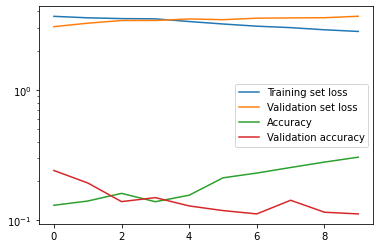

In [12]:
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model2.history.history['loss'])
    plt.plot(model2.history.history['val_loss'])
    plt.plot(model2.history.history['accuracy'])
    plt.plot(model2.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [15]:
y_pred = model2.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

28/28 [==============================] - 7s 240ms/step


In [16]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.2541793630217426
Accuracy :  0.26840317100792754
Precision score :  0.3398438085796252
Recall score :  0.26840317100792754


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Less complicated architecture

In [26]:
model = Sequential()
model.add(Input(shape=(IMG_SHAPE)))
model.add(tf.keras.layers.Reshape((64, 64*64*3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(64))
model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 64, 12288)         0         
                                                                 
 gru_4 (GRU)                 (None, 64, 32)            1182912   
                                                                 
 gru_5 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 80)                5200      
                                                                 
Total params: 1,206,928
Trainable params: 1,206,928
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
10/10 [==============================] - 10s 752ms/step - loss: 4.4238 - accuracy: 0.0068 - val_loss: 4.4125 - val_accuracy: 0.0136
Epoch 2/50
10/10 [==============================] - 8s 774ms/step - loss: 4.3882 - accuracy: 0.0221 - val_loss: 4.3996 - val_accuracy: 0.0169
Epoch 3/50
10/10 [==============================] - 7s 663ms/step - loss: 4.3651 - accuracy: 0.0136 - val_loss: 4.3965 - val_accuracy: 0.0203
Epoch 4/50
10/10 [==============================] - 6s 655ms/step - loss: 4.3470 - accuracy: 0.0238 - val_loss: 4.4043 - val_accuracy: 0.0102
Epoch 5/50
10/10 [==============================] - 6s 654ms/step - loss: 4.3510 - accuracy: 0.0221 - val_loss: 4.3999 - val_accuracy: 0.0102
Epoch 6/50
10/10 [==============================] - 6s 649ms/step - loss: 4.3326 - accuracy: 0.0289 - val_loss: 4.4038 - val_accuracy: 0.0102
Epoch 7/50
10/10 [==============================] - 6s 589ms/step - loss: 4.3204 - accuracy: 0.0170 - val_loss: 4.4052 - val_accuracy: 0.0068
Epoch

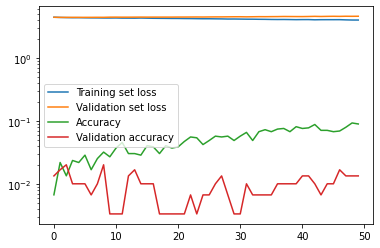

Epoch 1/50
10/10 [==============================] - 8s 762ms/step - loss: 4.2869 - accuracy: 0.0492 - val_loss: 4.0405 - val_accuracy: 0.0646
Epoch 2/50
10/10 [==============================] - 7s 668ms/step - loss: 4.2460 - accuracy: 0.0543 - val_loss: 4.0703 - val_accuracy: 0.0680
Epoch 3/50
10/10 [==============================] - 6s 643ms/step - loss: 4.2321 - accuracy: 0.0543 - val_loss: 4.0692 - val_accuracy: 0.0612
Epoch 4/50
10/10 [==============================] - 6s 632ms/step - loss: 4.2197 - accuracy: 0.0509 - val_loss: 4.1571 - val_accuracy: 0.0374
Epoch 5/50
10/10 [==============================] - 6s 636ms/step - loss: 4.1875 - accuracy: 0.0526 - val_loss: 4.1099 - val_accuracy: 0.0510
Epoch 6/50
10/10 [==============================] - 7s 688ms/step - loss: 4.1777 - accuracy: 0.0645 - val_loss: 4.1779 - val_accuracy: 0.0408
Epoch 7/50
10/10 [==============================] - 6s 628ms/step - loss: 4.1591 - accuracy: 0.0611 - val_loss: 4.1541 - val_accuracy: 0.0510
Epoch 

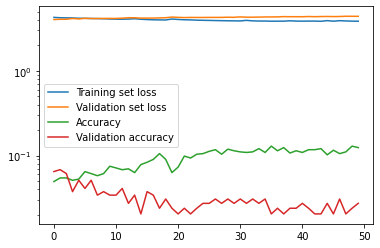

Epoch 1/50
10/10 [==============================] - 7s 688ms/step - loss: 4.1933 - accuracy: 0.0543 - val_loss: 3.8479 - val_accuracy: 0.1224
Epoch 2/50
10/10 [==============================] - 6s 638ms/step - loss: 4.1444 - accuracy: 0.0747 - val_loss: 3.8692 - val_accuracy: 0.1156
Epoch 3/50
10/10 [==============================] - 6s 642ms/step - loss: 4.1303 - accuracy: 0.0662 - val_loss: 3.9063 - val_accuracy: 0.1088
Epoch 4/50
10/10 [==============================] - 6s 638ms/step - loss: 4.1363 - accuracy: 0.0543 - val_loss: 3.9358 - val_accuracy: 0.1054
Epoch 5/50
10/10 [==============================] - 6s 630ms/step - loss: 4.1114 - accuracy: 0.0611 - val_loss: 3.9242 - val_accuracy: 0.1020
Epoch 6/50
10/10 [==============================] - 6s 640ms/step - loss: 4.0738 - accuracy: 0.0815 - val_loss: 3.9784 - val_accuracy: 0.0952
Epoch 7/50
10/10 [==============================] - 6s 639ms/step - loss: 4.0860 - accuracy: 0.0645 - val_loss: 3.9833 - val_accuracy: 0.0918
Epoch 

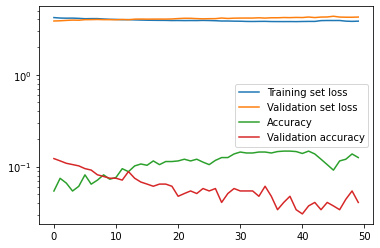

In [29]:
skf = StratifiedKFold(n_splits=3)
for train_index, test_index in skf.split(X, y_):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.legend(["Training set loss", "Validation set loss", "Accuracy", "Validation accuracy"])

    plt.yscale("log")
    plt.show()

In [30]:
y_pred = model.predict(X)         
y_pred = np.argmax(y_pred, axis = 1)

28/28 [==============================] - 9s 326ms/step


In [31]:
print("F1 score : ", f1_score(y_, y_pred, average = 'weighted'))
print("Accuracy : ", accuracy_score(y_, y_pred))
print("Precision score : ", precision_score(y_, y_pred, average = 'weighted'))
print("Recall score : ", recall_score(y_, y_pred, average = 'weighted'))

F1 score :  0.14116915190270843
Accuracy :  0.10985277463193659
Precision score :  0.40403332390611485
Recall score :  0.10985277463193659


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
